In [247]:
import numpy as np
import alphas3Momentos as tablas
from scipy.ndimage.interpolation import shift
import matplotlib.pylab as plt
import pandas as pd

In [61]:
def calcular_voladizo(tramo, pos_tramo):
    M = 0
    
    for car,caract in tramo['cargas'].items():
        
        if caract['tipo']  == 'puntual':
            if pos_tramo == 0:
                M += caract['magnitud'] * (tramo['L'] - caract['distancia'])
            else:
                M += caract['magnitud'] * (caract['distancia'])
                
                
        if caract['tipo']  == 'distribuida':
            if pos_tramo == 0:
                M += caract['magnitud'] * caract['longitud'] * (tramo['L'] - 0.5 * caract['longitud'] - caract['distancia'])
            else:
                M += caract['magnitud'] * caract['longitud'] * (0.5 * caract['longitud'] + caract['distancia'])
        
        
        if caract['tipo']  == 'triangular':
            dif = caract['dist_pico'] - caract['distancia']
            
            if pos_tramo == 0:
                if dif > 0:
                    M += 0.5 * caract['magnitud'] * caract['longitud'] * (tramo['L'] - caract['distancia'] - 2/3 * caract['longitud'])
                else:
                    M += 0.5 * caract['magnitud'] * caract['longitud'] * (tramo['L'] - caract['distancia'] - 1/3 * caract['longitud'])
            else:
                if dif > 0:
                    M += 0.5 * caract['magnitud'] * caract['longitud'] * (caract['distancia'] + 2/3 * caract['longitud'])
                else:
                    M += 0.5 * caract['magnitud'] * caract['longitud'] * (caract['distancia'] + 1/3 * caract['longitud'])
                
        if caract['tipo']  == 'momento':
            
            if pos_tramo == 0:
                M += -caract['magnitud']
            else:
                M += caract['magnitud']
                
        if caract['tipo']  == 'trapesoidal':
            dif = caract['dist_mayor'] - caract['dist_menor']
            dif_mag = caract['mag_mayor'] - caract['mag_menor']
            if pos_tramo == 0:
                if dif > 0:
                    M += 0.5 * dif_mag * caract['longitud'] * (tramo['L'] - caract['dist_menor'] - 2/3 * caract['longitud'])
                    M += caract['mag_menor'] * caract['longitud'] * (tramo['L'] - 0.5 * caract['longitud'] - caract['dist_menor'])
                else: 
                    M += 0.5 * dif_mag * caract['longitud'] * (tramo['L'] - caract['dist_mayor'] - 1/3 * caract['longitud'])
                    M += caract['mag_menor'] * caract['longitud'] * (tramo['L'] - 0.5 * caract['longitud'] - caract['dist_mayor'])
            else:
                if dif > 0:
                    M += 0.5 * dif_mag * caract['longitud'] * (caract['dist_menor'] + 2/3 * caract['longitud'])
                    M += caract['mag_menor'] * caract['longitud'] * (0.5 * caract['longitud'] + caract['dist_menor'])
                else: 
                    M += 0.5 * dif_mag * caract['longitud'] * (caract['dist_mayor'] + 1/3 * caract['longitud'])
                    M += caract['mag_menor'] * caract['longitud'] * (0.5 * caract['longitud'] + caract['dist_mayor'])
        
    if pos_tramo == 0:
        return -M
    else:
        return M

In [3]:
class viga():
    def __init__(self):
        self.tramos = []        
    
    def definir_tramos(self):
        aux = True
        while aux:
            voladizo = input("Es un voladizo? ")
            if voladizo != "si":
                empotrado = input("Es un empotramiento? ")
            else:
                empotrado = "no"
                
            n_cargas = int(input('Cuantas cargas hay en el tramo? '))
            
            cargas = {}
            
            for i in range(n_cargas):
                tipo_carga = input("Escriba el tipo de la carga " + str(i+1) + " ")
                
                if tipo_carga == "puntual":
                    
                    magnitud = float(input("Escriba la magnitud de la carga "))
                    distancia = float(input("Escriba la distancia de la carga al extremo izquierdo del tramo "))
                    
                    cargas['carga ' + str(i+1)]  = {
                        'tipo': tipo_carga,
                        'magnitud': magnitud,
                        'distancia': distancia
                    }
                    
            
                if tipo_carga == "distribuida":

                    magnitud = float(input("Escriba la magnitud de la carga "))
                    distancia = float(input("Escriba la distancia de la carga al extremo izquierdo del tramo "))
                    l_carga = float(input("Escriba la longitud de la carga "))

                    cargas['carga ' + str(i+1)]  = {
                        'tipo': tipo_carga,
                        'magnitud': magnitud,
                        'distancia': distancia,
                        'longitud': l_carga
                    }
                    
                
                if tipo_carga == "triangular":
                    
                    magnitud = float(input("Escriba la magnitud de la carga "))
                    distancia = float(input("Escriba la distancia de la carga al extremo izquierdo del tramo "))
                    dist_pico = float(input("Escriba la distancia del pico al extremo izquierdo del tramo "))
                    l_carga = float(input("Escriba la longitud de la carga "))

                    cargas['carga ' + str(i+1)]  = {
                        'tipo': tipo_carga,
                        'magnitud': magnitud,
                        'distancia': distancia,
                        'dist_pico': dist_pico,
                        'longitud': l_carga
                    }                    
                
                if tipo_carga == "momento":

                    magnitud = float(input("Escriba la magnitud de la carga "))
                    distancia = float(input("Escriba la distancia de la carga al extremo izquierdo del tramo "))
                    sentido = input("Escriba si es sentidio horario o antihorario ")
                    
                    if sentido == "horario":
                        magnitud = -magnitud
                    
                    cargas['carga ' + str(i+1)]  = {
                        'tipo': tipo_carga,
                        'magnitud': magnitud,
                        'distancia': distancia,
                        'sentido': sentido
                    }

                
                if tipo_carga == "trapesoidal":
                    
                    magnitud_M = float(input("Escriba la magnitud del lado mayor "))
                    distancia = float(input("Escriba la distancia de la carga al extremo izquierdo del tramo "))
                    dist_M = float(input("Escriba la distancia del lado mayor al extremo izquierdo del tramo "))
                    
                    magnitud_m = float(input("Escriba la magnitud del lado menor "))
                    dist_m = float(input("Escriba la distancia del lado menor al extremo izquierdo del tramo "))
                    
                    l_carga = float(input("Escriba la longitud de la carga "))
                    
                    cargas['carga ' + str(i+1)]  = {
                        'tipo': tipo_carga,
                        'distancia': distancia,
                        'mag_mayor': magnitud_M,
                        'dist_mayor': dist_M,
                        'mag_menor': magnitud_m,
                        'dist_menor': dist_m,
                        'longitud': l_carga
                    }
                
                print("----")
     
            L = float(input("Escriba la longitud del tramo "))
            
            tramo = {
                'voladizo': voladizo,
                'empotrado': empotrado,
                'cargas': cargas,
                'n_cargas': n_cargas,
                'L': L
            }
            
            self.tramos.append(tramo)
            
            mas_tramos = input("Hay mas tramos? ")
            
            print("----")
            print("----")
            print("\n")
            
            if mas_tramos == 'no':
                aux = False
        

In [12]:
Mi_viga = viga()

In [13]:
Mi_viga.tramos

[]

In [14]:
Mi_viga.definir_tramos()

Es un voladizo? si
Cuantas cargas hay en el tramo? 2
Escriba el tipo de la carga 1 puntual
Escriba la magnitud de la carga 1
Escriba la distancia de la carga al extremo izquierdo del tramo 0
----
Escriba el tipo de la carga 2 distribuida
Escriba la magnitud de la carga 2
Escriba la distancia de la carga al extremo izquierdo del tramo 0
Escriba la longitud de la carga 2
----
Escriba la longitud del tramo 2
Hay mas tramos? si
----
----


Es un voladizo? no
Es un empotramiento? no
Cuantas cargas hay en el tramo? 2
Escriba el tipo de la carga 1 puntual
Escriba la magnitud de la carga 3
Escriba la distancia de la carga al extremo izquierdo del tramo 3
----
Escriba el tipo de la carga 2 distribuida
Escriba la magnitud de la carga 2
Escriba la distancia de la carga al extremo izquierdo del tramo 3
Escriba la longitud de la carga 3
----
Escriba la longitud del tramo 6
Hay mas tramos? si
----
----


Es un voladizo? no
Es un empotramiento? no
Cuantas cargas hay en el tramo? 1
Escriba el tipo de 

In [15]:
Mi_viga.tramos

[{'voladizo': 'si',
  'empotrado': 'no',
  'cargas': {'carga 1': {'tipo': 'puntual', 'magnitud': 1.0, 'distancia': 0.0},
   'carga 2': {'tipo': 'distribuida',
    'magnitud': 2.0,
    'distancia': 0.0,
    'longitud': 2.0}},
  'n_cargas': 2,
  'L': 2.0},
 {'voladizo': 'no',
  'empotrado': 'no',
  'cargas': {'carga 1': {'tipo': 'puntual', 'magnitud': 3.0, 'distancia': 3.0},
   'carga 2': {'tipo': 'distribuida',
    'magnitud': 2.0,
    'distancia': 3.0,
    'longitud': 3.0}},
  'n_cargas': 2,
  'L': 6.0},
 {'voladizo': 'no',
  'empotrado': 'no',
  'cargas': {'carga 1': {'tipo': 'puntual',
    'magnitud': 4.0,
    'distancia': 2.0}},
  'n_cargas': 1,
  'L': 5.0},
 {'voladizo': 'no',
  'empotrado': 'no',
  'cargas': {'carga 1': {'tipo': 'distribuida',
    'magnitud': 2.0,
    'distancia': 0.0,
    'longitud': 5.0}},
  'n_cargas': 1,
  'L': 5.0}]

In [128]:
def calcular_empotrado(tramo, pos):
    b = 2 * tramo['L']
    c = tramo['L']
    d = calcular_d(tramo, tramo, empo = True, posempo = pos)
    
    return [b,c,d]

In [124]:
def coeficientes_momentos(tramo1, tramo2):
    a = tramo1['L']
    b = 2 * (tramo1['L'] + tramo2['L'])
    c = tramo2['L']
    d = calcular_d(tramo1,tramo2)
    
    return [a,b,c,d]

In [123]:
def calcular_d(tramo1, tramo2, empo = False, posempo = 0):
    b1 = 0
    b2 = 0
    
    if empo:
        
        if posempo == 0:
            
            for car, carac in tramo2['cargas'].items():

                if carac['tipo']  == 'puntual':
                    a1, _ = tablas.puntual(carac['magnitud'], carac['distancia'], tramo2['L'] - carac['distancia'], tramo2['L'])
                    b2 += a1

                if carac['tipo']  == 'distribuida':
                    if tramo2['L'] == carac['longitud']:
                        a1 = tablas.distribuida_total(carac['magnitud'], tramo2['L'])
                        b2 += a1

                    if carac['longitud'] == (tramo2['L'] - carac['longitud'] - carac['distancia']):
                        a1 = tablas.distribuida_media(carac['magnitud'], carac['longitud'], tramo2['L'])
                        b2 += a1

                    if carac['distancia'] == 0 and carac['longitud'] < tramo2['L']:
                        a1, _ = tablas.distribuida_parcial(carac['magnitud'], tramo2['L'], carac['longitud'])
                        b2 += a1

                    if carac['distancia'] == tramo2['L'] - carac['longitud'] and carac['longitud'] < tramo2['L']:
                        _, a2 = tablas.distribuida_parcial(carac['magnitud'], tramo2['L'], carac['longitud'])
                        b2 += a2

                if carac['tipo']  == 'momento':
                    a1, _ = tablas.momento(carac['magnitud'], tramo2['L'], carac['distancia'], tramo2['L'] - carac['distancia'])
                    b2 += a1

                if carac['tipo']  == 'triangular':
                    if tramo2['L'] == carac['longitud'] and tramo2['L'] / 2 == carac['dist_pico']:
                        a1 += tablas.piram_total(carac['magnitud'], tramo2['L'])
                        b2 += a1

                    if tramo2['L'] == carac['longitud'] and carac['dist_pico'] == 0:
                        a1, _ = tablas.triangular_total(carac['magnitud'], tramo2['L'])
                        b2 += a1

                    if tramo2['L'] == carac['longitud'] and carac['dist_pico'] == tramo2['L']:
                        _, a2 = tablas.triangular_total(carac['magnitud'], tramo2['L'])
                        b2 += a2                

                    if (tramo2['L'] - carac['longitud']) / 2 == carac['distancia'] and tramo2['L'] / 2 == carac['dist_pico']:
                        a1 = tablas.piram_media(carac['magnitud'], 0.5 * carac['longitud'], tramo2['L'])
                        b2 += a1

                    if tramo2['L'] > carac['longitud'] and carac['dist_pico'] == tramo2['L']:
                        _, a2 = tablas.triangular_lado(carac['magnitud'], carac['longitud'], tramo2['L'])
                        b2 += a2

                    if tramo2['L'] > carac['longitud'] and carac['dist_pico'] == 0:
                        a1, _ = tablas.triangular_lado(carac['magnitud'], carac['longitud'], tramo2['L'])
                        b2 += a1

                    if carac['dist_pico'] + carac['longitud'] == tramo2['L']:
                        _, a2 = tablas.triangular_punt(carac['magnitud'], carac['longitud'], tramo2['L'])
                        b2 += a2

                    if carac['distancia'] == 0 and carac['dist_pico'] == carac['longitud'] and carac['longitud'] < tramo2['L']:
                        a1, _ = tablas.triangular_punt(carac['magnitud'], carac['longitud'], tramo2['L'])
                        b2 += a1


                if carac['tipo']  == 'trapesoidal':

                    if carac['dist_mayor'] == carac['distancia'] and carac['dist_menor'] == tramo2['L']:
                        _, a21 = tablas.triangular_punt(carac['mag_mayor'] - carac['mag_menor'], carac['longitud'], tramo2['L'])
                        _, a22 = tablas.distribuida_parcial(carac['mag_menor'], tramo2['L'], carac['longitud'])
                        b2 += a21 + a22

                    if carac['dist_menor'] == carac['distancia'] and carac['dist_mayor'] == tramo2['L']:
                        _, a21 = tablas.triangular_lado(carac['mag_mayor'] - carac['mag_menor'], carac['longitud'], tramo2['L'])
                        _, a22 = tablas.distribuida_parcial(carac['mag_menor'], tramo2['L'], carac['longitud'])
                        b2 += a21 + a22

                    if carac['distancia'] == 0 and carac['dist_mayor'] == carac['longitud']:
                        a11, _ = tablas.triangular_punt(carac['mag_mayor'] - carac['mag_menor'], carac['longitud'], tramo2['L'])
                        a12, _ = tablas.distribuida_parcial(carac['mag_menor'], tramo2['L'], carac['longitud'])
                        b2 += a11 + a12

                    if carac['distancia'] == 0 and carac['dist_menor'] == carac['longitud']:
                        a11, _ = tablas.triangular_lado(carac['mag_mayor'] - carac['mag_menor'], carac['longitud'], tramo2['L'])
                        a12, _ = tablas.distribuida_parcial(carac['mag_menor'], tramo2['L'], carac['longitud'])
                        b1 += a11 + a12
            
        else:
        
            for car, carac in tramo1['cargas'].items():

                if carac['tipo']  == 'puntual':
                    _, a2 = tablas.puntual(carac['magnitud'], carac['distancia'], tramo1['L'] - carac['distancia'], tramo1['L'])
                    b1 += a2

                if carac['tipo']  == 'distribuida':
                    if tramo1['L'] == carac['longitud']:
                        a2 = tablas.distribuida_total(carac['magnitud'], tramo1['L'])
                        b1 += a2

                    if carac['longitud'] == (tramo1['L'] - carac['longitud'] - carac['distancia']):
                        a2 = tablas.distribuida_media(carac['magnitud'], carac['longitud'], tramo1['L'])
                        b1 += a2

                    if carac['distancia'] == 0 and carac['longitud'] < tramo1['L']:
                        _, a2 = tablas.distribuida_parcial(carac['magnitud'], tramo1['L'], carac['longitud'])
                        b1 += a2

                    if carac['distancia'] == tramo1['L'] - carac['longitud'] and carac['longitud'] < tramo1['L']:
                        a1, _ = tablas.distribuida_parcial(carac['magnitud'], tramo1['L'], carac['longitud'])
                        b1 += a1

                if carac['tipo']  == 'momento':
                    _, a2 = tablas.momento(carac['magnitud'], tramo1['L'], carac['distancia'], tramo1['L'] - carac['distancia'])
                    b1 += a2

                if carac['tipo']  == 'triangular':
                    if tramo1['L'] == carac['longitud'] and tramo1['L'] / 2 == carac['dist_pico']:
                        a2 += tablas.piram_total(carac['magnitud'], tramo1['L'])
                        b1 += a2 

                    if tramo1['L'] == carac['longitud'] and carac['dist_pico'] == 0:
                        _, a2 = tablas.triangular_total(carac['magnitud'], tramo1['L'])
                        b1 += a2

                    if tramo1['L'] == carac['longitud'] and carac['dist_pico'] == tramo['L']:
                        a1, _ = tablas.triangular_total(carac['magnitud'], tramo1['L'])
                        b1 += a1

                    if (tramo1['L'] - carac['longitud']) / 2 == carac['distancia'] and tramo1['L'] / 2 == carac['dist_pico']:
                        a2 = tablas.piram_media(carac['magnitud'], 0.5 * carac['longitud'], tramo1['L'])
                        b1 += a2

                    if tramo1['L'] > carac['longitud'] and carac['dist_pico'] == tramo1['L']:
                        a1, _ = tablas.triangular_lado(carac['magnitud'], carac['longitud'], tramo1['L'])
                        b1 += a1

                    if tramo1['L'] > carac['longitud'] and carac['dist_pico'] == 0:
                        _, a2 = tablas.triangular_lado(carac['magnitud'], carac['longitud'], tramo1['L'])
                        b1 += a2

                    if carac['dist_pico'] + carac['longitud'] == tramo1['L']:
                        a1, _ = tablas.triangular_punt(carac['magnitud'], carac['longitud'], tramo1['L'])
                        b1 += a1

                    if carac['distancia'] == 0 and carac['dist_pico'] == carac['longitud'] and carac['longitud'] < tramo1['L']:
                        _, a2 = tablas.triangular_punt(carac['magnitud'], carac['longitud'], tramo1['L'])
                        b1 += a2


                if carac['tipo']  == 'trapesoidal':

                    if carac['dist_mayor'] == carac['distancia'] and carac['dist_menor'] == tramo1['L']:
                        a11, _ = tablas.triangular_punt(carac['mag_mayor'] - carac['mag_menor'], carac['longitud'], tramo1['L'])
                        a12, _ = tablas.distribuida_parcial(carac['mag_menor'], tramo1['L'], carac['longitud'])
                        b1 += a12 + a11

                    if carac['dist_menor'] == carac['distancia'] and carac['dist_mayor'] == tramo1['L']:
                        a11, _ = tablas.triangular_lado(carac['mag_mayor'] - carac['mag_menor'], carac['longitud'], tramo1['L'])
                        a12, _ = tablas.distribuida_parcial(carac['mag_menor'], tramo1['L'], carac['longitud'])
                        b1 += a12 + a11

                    if carac['distancia'] == 0 and carac['dist_mayor'] == carac['longitud']:
                        _, a21 = tablas.triangular_punt(carac['mag_mayor'] - carac['mag_menor'], carac['longitud'], tramo1['L'])
                        _, a22 = tablas.distribuida_parcial(carac['mag_menor'], tramo1['L'], carac['longitud'])
                        b1 += a21 + a22

                    if carac['distancia'] == 0 and carac['dist_menor'] == carac['longitud']:
                        _, a21 = tablas.triangular_lado(carac['mag_mayor'] - carac['mag_menor'], carac['longitud'], tramo1['L'])
                        _, a22 = tablas.distribuida_parcial(carac['mag_menor'], tramo1['L'], carac['longitud'])
                        b1 += a21 + a22        
        
    else:
        
        for car, carac in tramo1['cargas'].items():

            if carac['tipo']  == 'puntual':
                _, a2 = tablas.puntual(carac['magnitud'], carac['distancia'], tramo1['L'] - carac['distancia'], tramo1['L'])
                b1 += a2

            if carac['tipo']  == 'distribuida':
                if tramo1['L'] == carac['longitud']:
                    a2 = tablas.distribuida_total(carac['magnitud'], tramo1['L'])
                    b1 += a2

                if carac['longitud'] == (tramo1['L'] - carac['longitud'] - carac['distancia']):
                    a2 = tablas.distribuida_media(carac['magnitud'], carac['longitud'], tramo1['L'])
                    b1 += a2

                if carac['distancia'] == 0 and carac['longitud'] < tramo1['L']:
                    _, a2 = tablas.distribuida_parcial(carac['magnitud'], tramo1['L'], carac['longitud'])
                    b1 += a2

                if carac['distancia'] == tramo1['L'] - carac['longitud'] and carac['longitud'] < tramo1['L']:
                    a1, _ = tablas.distribuida_parcial(carac['magnitud'], tramo1['L'], carac['longitud'])
                    b1 += a1

            if carac['tipo']  == 'momento':
                _, a2 = tablas.momento(carac['magnitud'], tramo1['L'], carac['distancia'], tramo1['L'] - carac['distancia'])
                b1 += a2

            if carac['tipo']  == 'triangular':
                if tramo1['L'] == carac['longitud'] and tramo1['L'] / 2 == carac['dist_pico']:
                    a2 += tablas.piram_total(carac['magnitud'], tramo1['L'])
                    b1 += a2 

                if tramo1['L'] == carac['longitud'] and carac['dist_pico'] == 0:
                    _, a2 = tablas.triangular_total(carac['magnitud'], tramo1['L'])
                    b1 += a2

                if tramo1['L'] == carac['longitud'] and carac['dist_pico'] == tramo['L']:
                    a1, _ = tablas.triangular_total(carac['magnitud'], tramo1['L'])
                    b1 += a1

                if (tramo1['L'] - carac['longitud']) / 2 == carac['distancia'] and tramo1['L'] / 2 == carac['dist_pico']:
                    a2 = tablas.piram_media(carac['magnitud'], 0.5 * carac['longitud'], tramo1['L'])
                    b1 += a2

                if tramo1['L'] > carac['longitud'] and carac['dist_pico'] == tramo1['L']:
                    a1, _ = tablas.triangular_lado(carac['magnitud'], carac['longitud'], tramo1['L'])
                    b1 += a1

                if tramo1['L'] > carac['longitud'] and carac['dist_pico'] == 0:
                    _, a2 = tablas.triangular_lado(carac['magnitud'], carac['longitud'], tramo1['L'])
                    b1 += a2

                if carac['dist_pico'] + carac['longitud'] == tramo1['L']:
                    a1, _ = tablas.triangular_punt(carac['magnitud'], carac['longitud'], tramo1['L'])
                    b1 += a1

                if carac['distancia'] == 0 and carac['dist_pico'] == carac['longitud'] and carac['longitud'] < tramo1['L']:
                    _, a2 = tablas.triangular_punt(carac['magnitud'], carac['longitud'], tramo1['L'])
                    b1 += a2


            if carac['tipo']  == 'trapesoidal':

                if carac['dist_mayor'] == carac['distancia'] and carac['dist_menor'] == tramo1['L']:
                    a11, _ = tablas.triangular_punt(carac['mag_mayor'] - carac['mag_menor'], carac['longitud'], tramo1['L'])
                    a12, _ = tablas.distribuida_parcial(carac['mag_menor'], tramo1['L'], carac['longitud'])
                    b1 += a12 + a11

                if carac['dist_menor'] == carac['distancia'] and carac['dist_mayor'] == tramo1['L']:
                    a11, _ = tablas.triangular_lado(carac['mag_mayor'] - carac['mag_menor'], carac['longitud'], tramo1['L'])
                    a12, _ = tablas.distribuida_parcial(carac['mag_menor'], tramo1['L'], carac['longitud'])
                    b1 += a12 + a11

                if carac['distancia'] == 0 and carac['dist_mayor'] == carac['longitud']:
                    _, a21 = tablas.triangular_punt(carac['mag_mayor'] - carac['mag_menor'], carac['longitud'], tramo1['L'])
                    _, a22 = tablas.distribuida_parcial(carac['mag_menor'], tramo1['L'], carac['longitud'])
                    b1 += a21 + a22

                if carac['distancia'] == 0 and carac['dist_menor'] == carac['longitud']:
                    _, a21 = tablas.triangular_lado(carac['mag_mayor'] - carac['mag_menor'], carac['longitud'], tramo1['L'])
                    _, a22 = tablas.distribuida_parcial(carac['mag_menor'], tramo1['L'], carac['longitud'])
                    b1 += a21 + a22




        for car, carac in tramo2['cargas'].items():

            if carac['tipo']  == 'puntual':
                a1, _ = tablas.puntual(carac['magnitud'], carac['distancia'], tramo2['L'] - carac['distancia'], tramo2['L'])
                b2 += a1

            if carac['tipo']  == 'distribuida':
                if tramo2['L'] == carac['longitud']:
                    a1 = tablas.distribuida_total(carac['magnitud'], tramo2['L'])
                    b2 += a1

                if carac['longitud'] == (tramo2['L'] - carac['longitud'] - carac['distancia']):
                    a1 = tablas.distribuida_media(carac['magnitud'], carac['longitud'], tramo2['L'])
                    b2 += a1

                if carac['distancia'] == 0 and carac['longitud'] < tramo2['L']:
                    a1, _ = tablas.distribuida_parcial(carac['magnitud'], tramo2['L'], carac['longitud'])
                    b2 += a1

                if carac['distancia'] == tramo2['L'] - carac['longitud'] and carac['longitud'] < tramo2['L']:
                    _, a2 = tablas.distribuida_parcial(carac['magnitud'], tramo2['L'], carac['longitud'])
                    b2 += a2

            if carac['tipo']  == 'momento':
                a1, _ = tablas.momento(carac['magnitud'], tramo2['L'], carac['distancia'], tramo2['L'] - carac['distancia'])
                b2 += a1

            if carac['tipo']  == 'triangular':
                if tramo2['L'] == carac['longitud'] and tramo2['L'] / 2 == carac['dist_pico']:
                    a1 += tablas.piram_total(carac['magnitud'], tramo2['L'])
                    b2 += a1

                if tramo2['L'] == carac['longitud'] and carac['dist_pico'] == 0:
                    a1, _ = tablas.triangular_total(carac['magnitud'], tramo2['L'])
                    b2 += a1

                if tramo2['L'] == carac['longitud'] and carac['dist_pico'] == tramo2['L']:
                    _, a2 = tablas.triangular_total(carac['magnitud'], tramo2['L'])
                    b2 += a2                

                if (tramo2['L'] - carac['longitud']) / 2 == carac['distancia'] and tramo2['L'] / 2 == carac['dist_pico']:
                    a1 = tablas.piram_media(carac['magnitud'], 0.5 * carac['longitud'], tramo2['L'])
                    b2 += a1

                if tramo2['L'] > carac['longitud'] and carac['dist_pico'] == tramo2['L']:
                    _, a2 = tablas.triangular_lado(carac['magnitud'], carac['longitud'], tramo2['L'])
                    b2 += a2

                if tramo2['L'] > carac['longitud'] and carac['dist_pico'] == 0:
                    a1, _ = tablas.triangular_lado(carac['magnitud'], carac['longitud'], tramo2['L'])
                    b2 += a1

                if carac['dist_pico'] + carac['longitud'] == tramo2['L']:
                    _, a2 = tablas.triangular_punt(carac['magnitud'], carac['longitud'], tramo2['L'])
                    b2 += a2

                if carac['distancia'] == 0 and carac['dist_pico'] == carac['longitud'] and carac['longitud'] < tramo2['L']:
                    a1, _ = tablas.triangular_punt(carac['magnitud'], carac['longitud'], tramo2['L'])
                    b2 += a1


            if carac['tipo']  == 'trapesoidal':

                if carac['dist_mayor'] == carac['distancia'] and carac['dist_menor'] == tramo2['L']:
                    _, a21 = tablas.triangular_punt(carac['mag_mayor'] - carac['mag_menor'], carac['longitud'], tramo2['L'])
                    _, a22 = tablas.distribuida_parcial(carac['mag_menor'], tramo2['L'], carac['longitud'])
                    b2 += a21 + a22

                if carac['dist_menor'] == carac['distancia'] and carac['dist_mayor'] == tramo2['L']:
                    _, a21 = tablas.triangular_lado(carac['mag_mayor'] - carac['mag_menor'], carac['longitud'], tramo2['L'])
                    _, a22 = tablas.distribuida_parcial(carac['mag_menor'], tramo2['L'], carac['longitud'])
                    b2 += a21 + a22

                if carac['distancia'] == 0 and carac['dist_mayor'] == carac['longitud']:
                    a11, _ = tablas.triangular_punt(carac['mag_mayor'] - carac['mag_menor'], carac['longitud'], tramo2['L'])
                    a12, _ = tablas.distribuida_parcial(carac['mag_menor'], tramo2['L'], carac['longitud'])
                    b2 += a11 + a12

                if carac['distancia'] == 0 and carac['dist_menor'] == carac['longitud']:
                    a11, _ = tablas.triangular_lado(carac['mag_mayor'] - carac['mag_menor'], carac['longitud'], tramo2['L'])
                    a12, _ = tablas.distribuida_parcial(carac['mag_menor'], tramo2['L'], carac['longitud'])
                    b1 += a11 + a12
                
    return -6 * (b1 + b2)

In [190]:
def calcular_momentos(Tramos):
    nrows = 0

    coeficientes = []
    for i in range(len(Tramos)-1):
        tramo1 = Tramos[i]
        tramo2 = Tramos[i+1]

        if tramo1['voladizo']  == 'si':
            M1 = calcular_voladizo(tramo1, 0)
            coeficientes.append([0, 1, 0, M1])

        elif tramo1['empotrado'] == 'si':
            coeficientes.append(calcular_empotrado(tramo1, 0))
            nrows += 1

        elif tramo2['voladizo'] == 'si':
            Mn = calcular_voladizo(tramo2, 1)
            coeficientes.append([0, 1, 0, Mn])

        elif tramo2['empotrado'] == 'si':
            coeficientes.append(calcular_empotrado(tramo2, 1))
            nrows += 1

        else:
            coeficientes.append(coeficientes_momentos(tramo1,tramo2))

        nrows += 1

    Matriz_A = np.zeros((nrows, len(Tramos)+1))
    Vector_B = np.zeros((nrows, 1))

    counter = 0

    for i in range(len(coeficientes)):
        if counter == 0 and Tramos[0]['empotrado'] == "si":
            Matriz_A[i,counter] = coeficientes[i][0]
            Matriz_A[i,counter+1] = coeficientes[i][1]        
            Vector_B[i] = coeficientes[i][-1]

        else:
            Matriz_A[i,counter] = coeficientes[i][0]
            Matriz_A[i,counter+1] = coeficientes[i][1]        
            Matriz_A[i,counter+2] = coeficientes[i][2]        

            Vector_B[i] = coeficientes[i][-1]

            counter += 1

    if Tramos[0]['voladizo']  == 'si':
        Matriz_A = Matriz_A[:,1:]
        Vector_B[1] = Vector_B[1] - Vector_B[0] * Matriz_A[1,0]
        Vector_B = Vector_B[1:]
        Matriz_A = Matriz_A[:,1:-1]
        Matriz_A = Matriz_A[1:,]

    elif Tramos[-1]['voladizo'] == 'si':
        Matriz_A = Matriz_A[:,:-1]
        Vector_B[-2] = Vector_B[-2] - Vector_B[-1] * Matriz_A[-2,-1]
        Vector_B = Vector_B[:-1]
        Matriz_A = Matriz_A[:,1:-1]
        Matriz_A = Matriz_A[:-1,:]

    elif Tramos[0]['empotrado'] == 'si':
        Matriz_A = Matriz_A[:,:-1]

    elif Tramos[-1]['empotrado'] == 'si':
        Matriz_A = Matriz_A[:,1:]

    elif Tramos[0]['empotrado'] == 'no':
        Matriz_A = Matriz_A[:,1:]

    elif Tramos[-1]['empotrado'] == 'no':
        Matriz_A = Matriz_A[:,:-1]

    sln = np.linalg.inv(Matriz_A).dot(Vector_B)[:,0].tolist()

    if Tramos[0]['voladizo']  == 'si':
        sln = [M1] + sln

    if Tramos[1]['voladizo'] == 'si':
        sln = sln + [Mn]
        
    if len(sln) <len(Tramos) + 1:
        if Tramos[0]['voladizo']  == 'si' or (Tramos[0]['voladizo']  == 'no' and Tramos[0]['empotrado']  == 'no'):
            sln = [0] + sln
            
        if Tramos[-1]['voladizo']  == 'si' or (Tramos[-1]['voladizo']  == 'no' and Tramos[-1]['empotrado']  == 'no'):
            sln = sln + [0]
    
    return sln

In [202]:
momentos = calcular_momentos(Mi_viga.tramos)
momentos

[0, -6.0, -3.837349397590361, -3.845662650602409, 0]

In [224]:
def calcular_sum_Fy(tramo):
    sumatotal = 0
    for car,carac in tramo['cargas'].items():
        
        if carac['tipo']  == 'puntual':
            sumatotal += carac['magnitud']

        if carac['tipo']  == 'distribuida':
            sumatotal += carac['magnitud'] * carac['longitud']

        if carac['tipo']  == 'triangular':
            sumatotal += 0.5 * carac['magnitud'] * carac['longitud']
            
        if carac['tipo']  == 'trapesoidal':
            sumatotal += 0.5 * (carac['mag_mayor'] + carac['mag_menor']) * carac['longitud']
    return sumatotal

In [236]:
def obtener_Rs(Tramos, momentos):
    Rs1 = []
    Rs2 = []

    for i in range(len(Tramos)):
        momen = (momentos[i], momentos[i+1])
        if Tramos[i]['voladizo'] == 'si' and i == 0:
            Rs1.append(0)
            Rs2.append(calcular_sum_Fy(Tramos[i]))

        elif Tramos[i]['voladizo'] == 'si':
            Rs1.append(calcular_sum_Fy(Tramos[i]))
            Rs2.append(0)

        else:
            Rs2.append(-(-calcular_voladizo(Tramos[i], 1) - momen[0] + momen[1]) / Tramos[i]['L'])
            Rs1.append(calcular_sum_Fy(Tramos[i]) - Rs2[i])

    Rs1 = np.array(Rs1)
    Rs2 = np.array(Rs2)

    R = Rs2 + shift(Rs1, -1)
    return R    

In [238]:
obtener_Rs(Tramos, momentos)

array([8.36044177, 8.03789558, 7.37079518, 4.23086747])

In [255]:
class graficador():
    def __init__(self):
        self.tipo = []
        self.magnitud = []
        self.longitud = []
        
        aux = True
        i = 0
        while aux:
            self.tipo.append(input("Escriba el tipo de la carga/reaccion " + str(i+1) + ": "))
            self.magnitud.append(float(input("Escriba la magnitud de la carga/reaccion: ")))
            self.longitud.append(float(input("Escriba la longitud de la carga/reaccion: ")))
            
            mas_pedazos = input("Hay mas trozos?: ")
            
            print("\n")
            
            i += 1
            
            if mas_pedazos == 'no':
                aux = False
        

In [256]:
Graficas = graficador()

Escriba el tipo de la carga/reaccion 1: puntual
Escriba la magnitud de la carga/reaccion: 1
Escriba la longitud de la carga/reaccion: 0
Hay mas trozos?: si


Escriba el tipo de la carga/reaccion 2: distribuida
Escriba la magnitud de la carga/reaccion: 2
Escriba la longitud de la carga/reaccion: 2
Hay mas trozos?: si


Escriba el tipo de la carga/reaccion 3: reaccion
Escriba la magnitud de la carga/reaccion: 8.361
Escriba la longitud de la carga/reaccion: 0
Hay mas trozos?: si


Escriba el tipo de la carga/reaccion 4: nada
Escriba la magnitud de la carga/reaccion: 0
Escriba la longitud de la carga/reaccion: 3
Hay mas trozos?: si


Escriba el tipo de la carga/reaccion 5: puntual
Escriba la magnitud de la carga/reaccion: 3
Escriba la longitud de la carga/reaccion: 0
Hay mas trozos?: si


Escriba el tipo de la carga/reaccion 6: distribuida
Escriba la magnitud de la carga/reaccion: 2
Escriba la longitud de la carga/reaccion: 3
Hay mas trozos?: si


Escriba el tipo de la carga/reaccion 7: re

In [263]:
ref = 0
Ltotal = 0

Y = [ref]
X = [Ltotal]

for i in range(len(Graficas.tipo)):
    if Graficas.tipo[i] == "puntual":
        ref += -Graficas.magnitud[i]
        Ltotal += Graficas.longitud[i]
    
    if Graficas.tipo[i] == "distribuida":
        ref += -Graficas.magnitud[i] * Graficas.longitud[i]
        Ltotal += Graficas.longitud[i]
        
    if Graficas.tipo[i] == "triangular":
        ref += -0.5 * Graficas.magnitud[i] * Graficas.longitud[i]
        Ltotal += Graficas.longitud[i]
    
    if Graficas.tipo[i] == "reaccion":
        ref += Graficas.magnitud[i]
        Ltotal += Graficas.longitud[i]
        
    if Graficas.tipo[i] == "nada":
        ref += Graficas.magnitud[i]
        Ltotal += Graficas.longitud[i]
        
    Y.append(ref)
    X.append(Ltotal)
    

In [264]:
X

[0, 0.0, 2.0, 2.0, 5.0, 5.0, 8.0, 8.0, 10.0, 10.0, 13.0, 13.0, 18.0, 18.0]

In [265]:
Y

[0,
 -1.0,
 -5.0,
 3.3610000000000007,
 3.3610000000000007,
 0.36100000000000065,
 -5.638999999999999,
 2.399000000000001,
 2.399000000000001,
 -1.600999999999999,
 -1.600999999999999,
 5.770000000000001,
 -4.229999999999999,
 0.0010000000000012221]

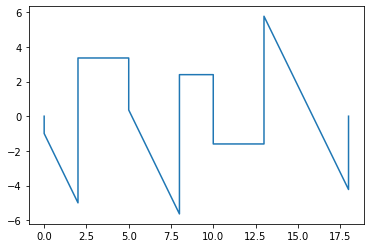

In [266]:
plt.figure()
plt.plot(X, Y)
plt.show()